In [1]:
import os
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.transforms import v2 as v2
from timm import create_model

# training history

In [3]:
conv = pd.read_csv('CoAtNet Metrics.csv')
conv

,epoch,train_loss,train_accuracy,test_loss,test_accuracy
0,1,1.224392,53.007768,1.038768,61.103371
1,2,0.958249,64.185447,0.989653,62.677626
2,3,0.840681,68.588248,0.927601,66.271942
3,4,0.727525,72.830820,0.905281,67.052104
4,5,0.424766,84.942004,0.947538,70.103093
...,...,...,...,...,...
75,76,0.179439,93.651699,0.218594,93.358098
76,77,0.184811,93.773939,0.218490,93.447251
77,78,0.173710,94.075462,0.217366,93.372957
78,79,0.177250,94.051015,0.218118,93.417533


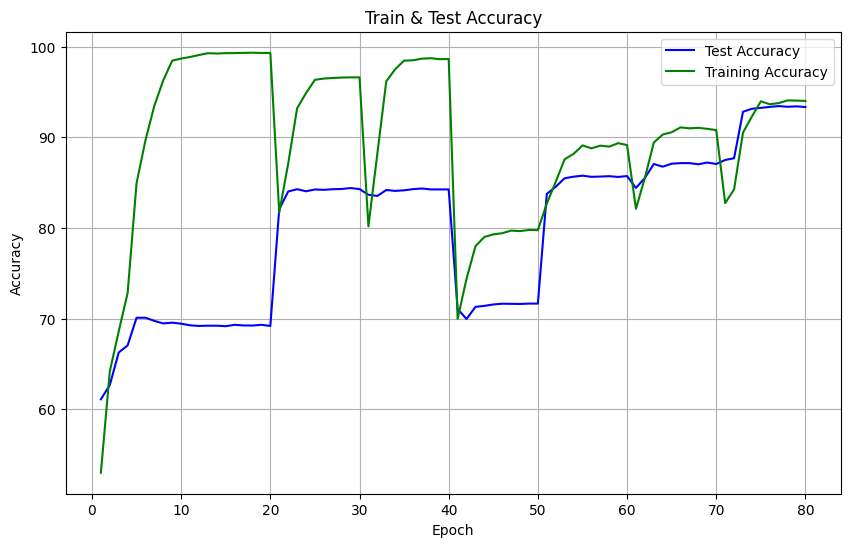

In [4]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.plot(conv['epoch'], conv['test_accuracy'], label='Test Accuracy', linestyle='-', color='blue')
plt.plot(conv['epoch'], conv['train_accuracy'], label='Training Accuracy', linestyle='-', color='green')

plt.title('Train & Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

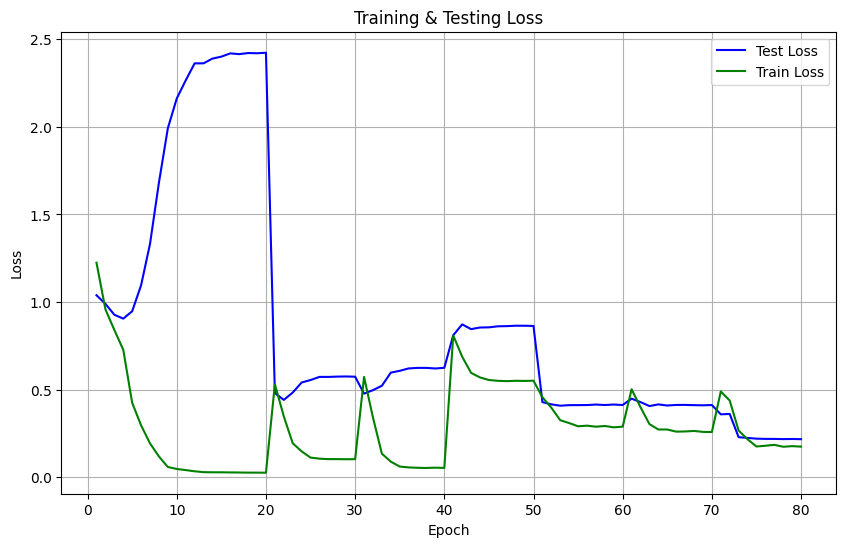

In [5]:
plt.figure(figsize=(10, 6))

plt.plot(conv['epoch'], conv['test_loss'], label='Test Loss', linestyle='-', color='blue')
plt.plot(conv['epoch'], conv['train_loss'], label='Train Loss', linestyle='-', color='green')

plt.title('Training & Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# model perf

In [2]:
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = create_model('coatnet_0_rw_224.sw_in1k', pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load('best_coatnet_FR(A)final.pth'))
model = model.to(device)

C:\Users\liamcee\AppData\Local\Temp\ipykernel_96244\305606507.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_coatnet_FR(A)final.p

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

test_dataset = datasets.ImageFolder("C:/Users/liamcee/Documents/farbruh/dataset/rafdb/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
class_names = test_dataset.classes


In [8]:
y_true = []
y_pred = []

device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


              precision    recall  f1-score   support

       anger       0.87      0.92      0.90       373
     disgust       0.82      0.75      0.78       375
        fear       0.81      0.73      0.77       139
   happiness       0.98      0.96      0.97      2617
     neutral       0.90      0.90      0.90      1437
     sadness       0.89      0.93      0.91      1073
    surprise       0.91      0.92      0.92       716

    accuracy                           0.92      6730
   macro avg       0.88      0.87      0.88      6730
weighted avg       0.92      0.92      0.92      6730



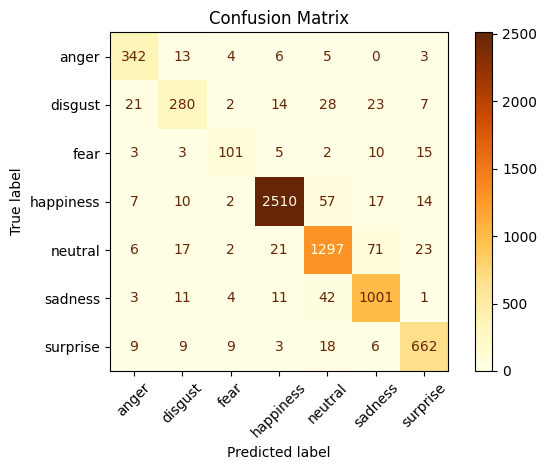

In [9]:
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='YlOrBr', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [3]:
transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root='C:/Users/liamcee/Documents/farbruh/rafdb/train', transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [4]:
inference_times = []

with torch.no_grad():
    for images, _ in loader:
        images = images.to(device)
        
        start_time = time.time()
        _ = model(images)
        end_time = time.time()
        
        inference_time = end_time - start_time
        inference_times.append(inference_time)

# Report average time
average_time = sum(inference_times) / len(inference_times)
print(f"Average inference time per image: {average_time:.6f} seconds")


Average inference time per image: 0.010161 seconds
